# 9. Problema de máxima diversidad

Implementar en Python un algoritmo evolutivo para el problema de máxima diversidad, tal y como se define en https://grafo.etsii.urjc.es/optsicom/mdp.html. Comparar las dos siguientes versiones del algoritmo para el manejo de las restricciones:

– **AE1: External feasibility first** (Tema 2, pág. 78). Dado que solo hay una restricción, las versiones max y sum de feasibility first externo descritas en el Tema 2 de la asignatura son equivalentes. El problema es de maximización, por lo que se transformará a un problema de minimización. La función objetivo resultante es la siguiente:

$\min F(x) = \begin{cases} 
-\sum\limits_{i=1}^{n-1} \sum\limits_{j=i+1}^{n} d_{ij} x_i x_j & \text{si } \sum\limits_{i=1}^n x_i = 0 \\
\lvert \sum\limits_{i=1}^n x_i - m \rvert & \text{en otro caso}
\end{cases}$

– **AE2: Algoritmo de reparo** (Tema 2, pág. 76).

– **AE3 (añadido): Algoritmo con representación permutacional**: Se aprovecha la representación permutacional para que todos los individuos sean factibles. Cada individuo se representa por una permutación $[p_1, ..., p_n]$. Se seleccionan los primeros $m$ individuos de la permutación ($x_{p_i}=1 \, \forall i \le m$).

Para las comparaciones, generar aleatoriamente 3 problemas de test con las siguientes características:

– **Problema de test 1**: $ n = 100, m = 10, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 2**: $ n = 150, m = 15, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 3**: $ n = 200, m = 20, K = 1, s_{ij} ∈ [0, 10]$.


Se realizará ajuste de parámetros con una **grid search** configurada de la
siguiente forma:

- Algoritmos evolutivos (proyectos 1 a 7, 9 y 10): grid search de 10x10, 3 repeticiones, probabilidad de cruce en el intervalo (0.0, 1.0], y probabilidad de mutación en el intervalo (0.0, 0.3], 100000 evaluaciones de la función objetivo en los proyectos 1 a 7, y 3000 evaluaciones en proyectos 9 y 10. En el proyecto 5, los operadores de mutación polinomial y “small” se aplican uno u otro con probabilidad 0.5.

Una vez identificados los valores de los parámetros, se realizarán **10 runs** con esos parámetros y diferentes semillas, con 300000 evaluaciones en los proyectos 1 a 8, y 10000 evaluaciones en los proyectos 9 y 10.

- Se reportará media, máximo, mínimo y desviación estándar para cada problema y algoritmo.

- Se realizará un ranking wins-losses de los resultados medios y de las diferencias estadísticamente significativas (Wilcoxon rank-sum test).

- Se entregará un documento Jupyter Notebook en Python con el código, comentarios, resultados, visualización gráfica de la evolución de los algoritmos (las 10 runs sobre el mismo gráfico), análisis y discusión de resultados y conclusiones.

# Algoritmo evolutivo para optimización con restricciones – External feasibility first – max version

### Descripción

<font size="4"> Algoritmo evolutivo para optimización continua con restricciones (minimización), enfoque "primero factibilidad", externo, versión max.

### Componentes

- Representación binaria.

- Manejo de restricciones con enfoque "primero factibilidad", externo, versión max

- Selección por torneo binario

- Muestreo estocástico con reemplazamiento

- Sustitución $(\mu+\lambda)$

- Elitista

- Cruce simple.

- Mutación bitflip.
   
### Comentarios
    
- Se requiere ordenar una población de $2 N$ individuos con los $\mu$ padres más los $\lambda$ hijos, $\mu=\lambda=N$.   
    
---

### Requerimientos

In [1]:
import numpy as np
import heapq 
from tqdm import tqdm
import matplotlib.pyplot as plt
import landscapes.single_objective as lso
from scipy.spatial import distance_matrix
import os
import pandas as pd
import csv
from scipy.stats import wilcoxon, mannwhitneyu
from statistics import mean

profiling = True # Poner a True para hacer profiling
results_dir = 'cbio_p9_results' if not profiling else 'cbio_p9_results_profiling' # Directorio de resultados
done = False # os.path.isdir(results_dir) # Poner a False para ejecutar las pruebas
np.random.seed(0)   # Establecer semilla

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones. El número de evaluaciones será $2GN$.
- $N$: Tamaño de la población
- $random\_state$: Semilla para reproducibilidad
- $prob$: Probabilidades
  - $p\_c$: Probabilidad de cruce. El cruce será simple.
  - $p\_m$: Probabilidades de mutación. La mutación será bitflip.


### Definición del problema de optimización con restricciones (Máxima diversidad)
- $n$: Número de instancias del dataset (puntos de la nube de puntos).
- $k$: Dimensionalidad de la nube de puntos.
- $L$: Límite inferior de espacio muestral del dataset. 
- $U$: Límite superior de espacio muestral del dataset. Los puntos del dataset serán $s_i \in [L, U]^k \quad \forall i = 1, ..., n$.
- $f$: Función objetivo (máxima diversidad).
- $maxf$:  Máximo (aproximado) de la función $f$

In [2]:
# Problema de máxima diversidad

def diversity_obj(x, d):
    """
    Función objetivo del problema de máxima diversidad.
    x: representación binaria de un individuo. 
    d: matriz de distancias del dataset.
    """
    return -(x.T @ d @ x) # Cambiamos el signo para transformar el problema en uno de minimización

def maxDiversity_constraints(x, m):
    return np.array([np.abs(np.sum(x)-m)])

class diversity_problem:
    def __init__(self, n, m, k=1, L=0, U=10):
        self.n = n
        self.m = m
        self.k = k
        self.L = L
        self.U = U
        self.X = np.random.uniform(L, U, (n, k))     # Dataset de n puntos en [L, U]
        #if k==1:
        #    self.X = np.sort(self.X, axis=0)        # Ordena los puntos de menor a mayor
        
        self.d = np.triu(distance_matrix(self.X, self.X))   # Matriz de distancias de los puntos del dataset (n x n)
                                                            # Extraemos la parte triangular superior para evitar sumar distancias repetidas
                                                            
        self.f = lambda x: diversity_obj(x, self.d)  # Función objetivo
        self.g = lambda x: maxDiversity_constraints(x, m) # Restricciones
        self.maxf = 0

### Transformación del problema con restricciones en un problema sin restricciones – versión max

In [3]:
def transformed_problem(x,f,g,maxf):
    maxg = max(g(x))
    if maxg <= 0.0:
        return f(x)
    else:
        return maxf+maxg

### Definición de individuo

In [4]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n, dtype=int)
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [5]:
def InitializePopulation(P):
    for I in P:
        I.x[:] = np.random.randint(2, size=len(I.x))

def InitializePopulationPermutation(P):
    for I in P:
        I.x[:] = np.random.permutation(len(I.x))

### Función de evaluación

In [6]:
def evaluate_EFF(I,f, g, maxf):           
    I.f = transformed_problem(I.x,f,g,maxf)

def perm2bin(x, m):
    """
    Devuelve la representación binaria de un individuo representado mediante una permutación.
    x: permutación.
    m: los primeros m elementos de la permutación se ponen a 1's.
    """
    n = len(x)
    y = np.zeros(n, dtype=int)
    y[x[:m]] = 1
    return y

def evaluate_permutation(I, problem):
    I.f = problem.f(perm2bin(I.x, problem.m))

In [7]:
x = np.array([0,1,2,3,4,5,6,7,8,9])

### Copia de individuo

In [8]:
def copia(I1, I2):
    """
        Copia I2 en I1
    """
    np.copyto(I1.x, I2.x)
    I1.f = I2.f

### Selección por torneo binario

In [9]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Cruce
- Cruce con probabilidad $p\_c$ y:
    - cruce uniforme (con probabilidad $uniform\_crossover\_probability$)
    - cruce aritmético (con probabilidad $arithmetic\_crossover\_probability$)
    - cruce SBX en otro caso

In [10]:
def uniform_crossover(x1,x2):
    for l in range(x1.size):
        if np.random.random()<=0.5:
            x1[l], x2[l] = x2[l], x1[l] 
            
def simple_crossover(x1,x2):
    pos = np.random.randint(x1.size)
    x1[:], x2[:] = np.hstack((x1[:pos],x2[pos:])), np.hstack((x2[:pos],x1[pos:]))
        
def crossover(x1,x2,prob_cross): # Cruce simple
    if np.random.random()<=prob_cross:
        simple_crossover(x1,x2)

aux_mem = np.arange(10) # Memoria auxiliar para PMX para evitar reservar memoria en cada llamada

def pmx(x1, x2):
    global aux_mem
    if aux_mem.size != x1.size:
        aux_mem = np.arange(x1.size, dtype=int)
    else:
        for i in range(x1.size):
            aux_mem[i] = i
    pos1 = np.random.randint(x1.size)
    pos2 = np.random.randint(x1.size)
    if pos1 > pos2:
        pos1, pos2 = pos2, pos1
    for i in range(pos1, pos2):
        aux_mem[x1[i]] = x2[i]
        aux_mem[x2[i]] = x1[i]
    x1[pos1:pos2], x2[pos1:pos2] = x2[pos1:pos2], x1[pos1:pos2]
    x1[:pos1] = aux_mem[x1[:pos1]]
    x2[:pos1] = aux_mem[x2[:pos1]]
    x1[pos2:] = aux_mem[x1[pos2:]]
    x2[pos2:] = aux_mem[x2[pos2:]]

def pmx_crossover(x1, x2, prob_cross):
    if np.random.random()<=prob_cross:
        pmx(x1,x2)

### Mutación

Definimos los siguientes operadores de mutación:

- Mutación bitflip: para la representación binaria.
- Mutación por intercambio recíproco: para la representación permutacional.

In [11]:
def bitflip_mutation(x,p_m):
    for l in range(x.size):
        if np.random.random()<=p_m:
            x[l] = 1-x[l]

def mutation(x,prob_mutation):
    bitflip_mutation(x, prob_mutation)

def exchange_mutation(x, prob_mutation):
    if np.random.random()<=prob_mutation:
        pos1 = np.random.randint(x.size)
        pos2 = np.random.randint(x.size)
        x[pos1], x[pos2] = x[pos2], x[pos1]

## Algoritmo de reparo

In [12]:
def maxDiversity_repair(x, m):
    """
    Reparación de la solución x para cumplir las restricciones del problema de máxima diversidad. Se realiza inplace.
    x: representación binaria de un individuo. 
    m: número de elementos a seleccionar.
    """
    v = np.sum(x)
    if v != m:
        if v > m:
            # Eliminar elemento
            x[np.random.choice(np.where(x == 1)[0], size=v-m, replace=False)] = 0
        else:
            # Añadir un elemento
            x[np.random.choice(np.where(x == 0)[0], size=m-v, replace=False)] = 1

def repair_and_evaluate(I, m, f):
    """
    Repara el individuo I si no cumple las restricciones y evalúa su función objetivo.
    """
    maxDiversity_repair(I.x, m)
    I.f = f(I.x)

### Progreso del algoritmo

In [13]:
def IniciaProgreso(P,G, feasibility, problem):
    best_outputs_f = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    best_outputs_g = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs_f,best_outputs_g,progression_bar, feasibility, problem)    
    return best_outputs_f,best_outputs_g,progression_bar
    
def ActualizaProgreso(P,gen,best_outputs_f,best_outputs_g,progression_bar, feasibility, problem):
    best_individuo = min(P)
    best_g = feasibility(best_individuo, problem)
    progression_bar.set_description("Generation: %s Objective: %s Feasibility: %s " % (str(gen), str(best_individuo.f), str(best_g)))
    best_outputs_f[gen] = best_individuo.f # Añadir mejor fitness (para visualización)
    best_outputs_g[gen] = best_g
    progression_bar.update(1)

### Algoritmo evolutivo

In [14]:
class EAOperators:
    """
    Clase que encapsula los operadores de un algoritmo evolutivo.
    """
    def __init__(self, initialize_population, evaluate, select, cross, mutate, feasibility):
        """
        initialize_population: función de inicialización de la población. initialize_population(P:List[Individuo]).
        evaluate(I:Individuo): función de evaluación de un individuo. evaluate(I:Individuo, problem: diversity_problem).
        select: operador de selección de padres. select(P:List[Individuo]) -> Individuo.
        cross: operador de cruce. cross(x1:np.array, x2:np.array, prob_cross:float).
        mutate: operador de mutación. mutate(I:Individuo, prob_mutation:float).
        feasibility: función g que evalúa la factibilidad de un individuo. feasibility(I: Individuo, problem: diversity_problem) -> double.
        """
        self.initialize_population = initialize_population
        self.evaluate = evaluate
        self.select = select
        self.cross = cross
        self.mutate = mutate
        self.feasibility = feasibility

def EA(G,N,prob,problem,ops,random_state):
    """
    Algoritmo evolutivo para el problema de máxima diversidad con representación binaria y manejo de restricciones por External Feasibility First.
    G: número de generaciones.
    N: tamaño de la población.
    ops: operadores del algoritmo evolutivo (EAOperators).
    random_state: semilla para la generación de números aleatorios.
    """
    np.random.seed(random_state)
    
    p_c, p_m = prob
    initialize_population = ops.initialize_population
    evaluate = ops.evaluate
    select = ops.select
    cross = ops.cross
    mutate = ops.mutate

    # Aserciones
    
    assert G >= 1, "El número de evaluaciones debe ser mayor o igual que 1."  
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    
    def AssertProbability(p):
        assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

    AssertProbability(p_c)
    
    AssertProbability(p_m)
    
    # Parámetros del problema
    n = problem.n

    # Crear población inicial con N individuos
    P = [Individuo(n) for _ in range(N)]
    initialize_population(P)
    
    # Evaluar población inicial
    for I in P:
        evaluate(I,problem)
    
    # Crear población auxilar 
    Q = [Individuo(n) for _ in range(2*N)]
    
    # Evoluciona durante G generaciones
    best_outputs_f,best_outputs_g,progression_bar = IniciaProgreso(P,G, feasibility, problem)    
    for gen in range(1,G+1):
        for i in range(N):
            copia(Q[i],P[i])
        i=N
        while i < 2*N:
            copia(Q[i],select(P))
            copia(Q[i+1],select(P))
            cross(Q[i].x,Q[i+1].x,p_c)
            mutate(Q[i].x,p_m)
            mutate(Q[i+1].x,p_m)
            evaluate(Q[i],problem)
            evaluate(Q[i+1],problem)
            i += 2  
        R = heapq.nsmallest(N,Q)
        for i in range(N):
            copia(P[i],R[i])
        ActualizaProgreso(P,gen,best_outputs_f,best_outputs_g,progression_bar, feasibility, problem)
        # print([I.x for I in P])
    best_individuo = min(P)
    return best_outputs_f,best_outputs_g, best_individuo.f, best_individuo.x

def evaluate_AE1(I, problem):
    return evaluate_EFF(I, problem.f, problem.g, problem.maxf)

def evaluate_AE2(I, problem):
    return repair_and_evaluate(I, problem.m, problem.f)

def feasibility(I, problem):
    return max(problem.g(I.x))

def feasibility_perm(I, problem):
    return 0    # Todos los individuos representados con una permutación son factibles

ops_list = [EAOperators(InitializePopulation, evaluate_AE1, binary_tournament_selection, crossover, mutation, feasibility), 
                  EAOperators(InitializePopulation, evaluate_AE2, binary_tournament_selection, crossover, mutation, feasibility), 
                  EAOperators(InitializePopulationPermutation, evaluate_permutation, binary_tournament_selection, pmx_crossover, exchange_mutation, feasibility_perm)]

## Definición de los problemas de test

Se generan aleatoriamente 3 problemas de test con las siguientes características:

– **Problema de test 1**: $ n = 100, m = 10, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 2**: $ n = 150, m = 15, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 3**: $ n = 200, m = 20, K = 1, s_{ij} ∈ [0, 10]$.

– **Problema de test 4 (adicional)**: $n = 200, m=20, K=7, s_{ij} \in [0, 10]$.

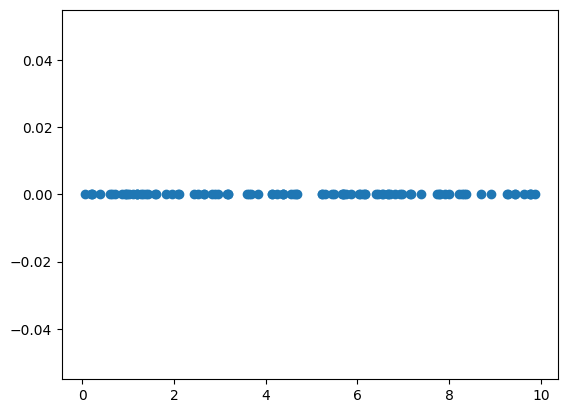

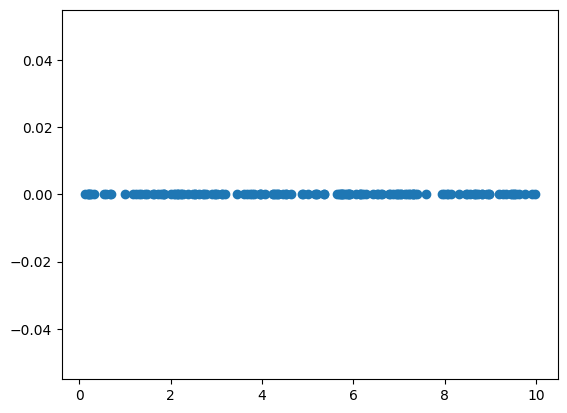

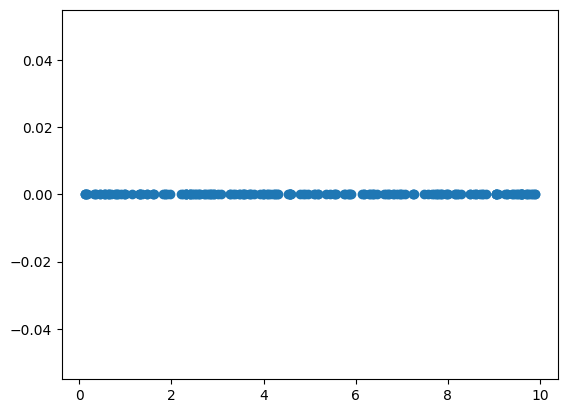

In [15]:
problems = [diversity_problem(100, 10), diversity_problem(150, 15), diversity_problem(200, 20), diversity_problem(200, 20, 7)]

for problem in problems:
    if problem.k == 1:
        plt.scatter(problem.X, np.zeros(problem.n))
        plt.show()

## Definición del Grid Search

- Se van a ajustar los siguientes parámetros del EA:
  - $p\_c$ (Probabilidad de cruce)
  - $p\_m$ (Probabilidad de mutación)

In [16]:
options = {'p_c': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
           'p_m': [1e-4,5e-4,1e-3,5e-3,0.01,0.05,0.1, 0.15, 0.2, 0.3]} \
        if not profiling else \
            {'p_c': [0.7, 0.8], 'p_m': [0.01, 0.05]}

In [17]:
def GridSearchEA(options, n_repeat, G, N, problem, ops):    
    best_score = float('inf')
    best_options = None
    for p_c in options['p_c']:
        for p_m in options['p_m']:
            score = np.zeros(n_repeat)
            print("p_c:",p_c," p_m:",p_m)
            for i in range(n_repeat):
                prob = p_c, p_m
                _, _, score[i], _ = EA(G, N, prob, problem, ops, random_state = i)
            scoreMean = score.mean()
            print("Score Mean: ",scoreMean)
            print("")
            if scoreMean < best_score:
                best_score = scoreMean
                best_options = {'p_c': p_c, 'p_m': p_m}
    return best_score, best_options

### Ejecución del Grid Search

In [18]:
# Crea un directorio para guardar archivos con los resultados
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [19]:
N = 100
evals = 200000 # Aumentamos el número de evaluaciones
G = evals//(2*N) if not profiling else 50

n_repeat = 3


best_scores = []
best_options_list = []

algorithm_names = ['AE1', 'AE2', 'AE3']

if not done:
    for ops, algorithm_name in zip(ops_list, algorithm_names):
        for nproblem, problem in enumerate(problems):
            print("ALGORITMO: ", algorithm_name)
            print("PROBLEMA DE TEST ", nproblem+1)
            print("n: ", problem.n, " m: ", problem.m, " k: ", problem.k, " L: ", problem.L, " U: ", problem.U)

            best_score, best_options = GridSearchEA(options=options,n_repeat=n_repeat,G=G,N=N,problem=problem, ops=ops)

            best_scores.append(best_score)
            best_options_list.append(best_options)
            
            print("BEST:")
            print(best_score)
            print(best_options)

    df = pd.DataFrame(columns=['algorithm', 'problem', 'n', 'm', 'k', 'L', 'U', 'gs_best_score', 'best_options'])
    df['algorithm'] = [algorithm_name for algorithm_name in algorithm_names for _ in range(len(problems))]
    df['problem'] = list(range(1, len(problems)+1)) * len(algorithm_names)
    df['n'] = [problem.n for problem in problems] * len(algorithm_names)
    df['m'] = [problem.m for problem in problems] * len(algorithm_names)
    df['k'] = [problem.k for problem in problems] * len(algorithm_names)
    df['L'] = [problem.L for problem in problems] * len(algorithm_names)
    df['U'] = [problem.U for problem in problems] * len(algorithm_names)
    df['gs_best_score'] = best_scores
    df['best_options'] = best_options_list

    df.to_csv(os.path.join(results_dir, f'cbio_p9_grid_search.csv'), index=False)
else:
    df = pd.read_csv(os.path.join(results_dir, f'cbio_p9_grid_search.csv'))

ALGORITMO:  AE1
PROBLEMA DE TEST  1
n:  100  m:  10  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -225.1650060599563 Feasibility: 0 : : 51it [00:01, 39.66it/s] 
Generation: 50 Objective: -215.0884198771594 Feasibility: 0 : : 51it [00:01, 46.65it/s] 
Generation: 50 Objective: -227.24545325257185 Feasibility: 0 : : 51it [00:01, 37.59it/s]


Score Mean:  -222.49962639656255

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -171.4180003489467 Feasibility: 0 : : 51it [00:00, 61.80it/s] 
Generation: 50 Objective: -190.46596818553263 Feasibility: 0 : : 51it [00:01, 43.67it/s]
Generation: 50 Objective: -215.71514034370173 Feasibility: 0 : : 51it [00:01, 36.42it/s]


Score Mean:  -192.53303629272702

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -215.8617406597743 Feasibility: 0 : : 51it [00:01, 41.57it/s] 
Generation: 50 Objective: -216.10782393670146 Feasibility: 0 : : 51it [00:01, 33.50it/s]
Generation: 50 Objective: -225.2568459658196 Feasibility: 0 : : 51it [00:01, 42.80it/s] 


Score Mean:  -219.07547018743176

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -187.63482406915335 Feasibility: 0 : : 51it [00:00, 56.21it/s]
Generation: 50 Objective: -210.1292088200486 Feasibility: 0 : : 51it [00:01, 49.50it/s] 
Generation: 50 Objective: -195.8502428985031 Feasibility: 0 : : 51it [00:00, 56.96it/s] 


Score Mean:  -197.87142526256835

BEST:
-222.49962639656255
{'p_c': 0.7, 'p_m': 0.01}
ALGORITMO:  AE1
PROBLEMA DE TEST  2
n:  150  m:  15  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -463.70177952560516 Feasibility: 0 : : 51it [00:01, 48.58it/s]
Generation: 50 Objective: -399.8257737756811 Feasibility: 0 : : 51it [00:01, 50.42it/s] 
Generation: 50 Objective: -430.364633924686 Feasibility: 0 : : 51it [00:01, 47.02it/s]  


Score Mean:  -431.2973957419908

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 59.11it/s]  
Generation: 50 Objective: 1 Feasibility: 1 : : 51it [00:00, 64.46it/s]  
Generation: 50 Objective: 5 Feasibility: 5 : : 51it [00:00, 63.21it/s]  


Score Mean:  3.6666666666666665

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -442.89696408977636 Feasibility: 0 : : 51it [00:01, 46.28it/s]
Generation: 50 Objective: -460.1502707571045 Feasibility: 0 : : 51it [00:01, 44.74it/s] 
Generation: 50 Objective: -419.2435678291313 Feasibility: 0 : : 51it [00:01, 39.99it/s] 


Score Mean:  -440.76360089200404

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: 3 Feasibility: 3 : : 51it [00:00, 60.53it/s]  
Generation: 50 Objective: 4 Feasibility: 4 : : 51it [00:00, 64.08it/s]  
Generation: 50 Objective: 2 Feasibility: 2 : : 51it [00:00, 62.15it/s]  


Score Mean:  3.0

BEST:
-440.76360089200404
{'p_c': 0.8, 'p_m': 0.01}
ALGORITMO:  AE1
PROBLEMA DE TEST  3
n:  200  m:  20  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -727.9836788926702 Feasibility: 0 : : 51it [00:00, 53.71it/s]
Generation: 50 Objective: -663.081754017868 Feasibility: 0 : : 51it [00:01, 50.59it/s] 
Generation: 50 Objective: -727.9719183513824 Feasibility: 0 : : 51it [00:00, 51.24it/s]


Score Mean:  -706.3457837539736

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 54.00it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 55.60it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 56.69it/s]  


Score Mean:  10.333333333333334

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -804.8167108306026 Feasibility: 0 : : 51it [00:00, 53.70it/s]
Generation: 50 Objective: -733.2585118144722 Feasibility: 0 : : 51it [00:01, 48.92it/s]
Generation: 50 Objective: -800.2280682446121 Feasibility: 0 : : 51it [00:01, 49.98it/s]


Score Mean:  -779.4344302965623

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 52.54it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 56.68it/s]  
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 55.61it/s]


Score Mean:  12.666666666666666

BEST:
-779.4344302965623
{'p_c': 0.8, 'p_m': 0.01}
ALGORITMO:  AE1
PROBLEMA DE TEST  4
n:  200  m:  20  k:  7  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -2183.0589947934704 Feasibility: 0 : : 51it [00:00, 51.71it/s]
Generation: 50 Objective: -2211.282822833411 Feasibility: 0 : : 51it [00:01, 50.28it/s] 
Generation: 50 Objective: -2249.189112638168 Feasibility: 0 : : 51it [00:01, 49.70it/s] 


Score Mean:  -2214.51031008835

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: 10 Feasibility: 10 : : 51it [00:00, 55.09it/s]
Generation: 50 Objective: 14 Feasibility: 14 : : 51it [00:00, 58.19it/s]
Generation: 50 Objective: 7 Feasibility: 7 : : 51it [00:00, 56.51it/s]  


Score Mean:  10.333333333333334

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -2094.5849494233307 Feasibility: 0 : : 51it [00:00, 53.58it/s]
Generation: 50 Objective: -2140.5353899155634 Feasibility: 0 : : 51it [00:01, 45.56it/s]
Generation: 50 Objective: -2130.519268497089 Feasibility: 0 : : 51it [00:01, 48.61it/s] 


Score Mean:  -2121.879869278661

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: 18 Feasibility: 18 : : 51it [00:00, 55.03it/s]
Generation: 50 Objective: 8 Feasibility: 8 : : 51it [00:00, 55.89it/s]  
Generation: 50 Objective: 12 Feasibility: 12 : : 51it [00:00, 59.40it/s]


Score Mean:  12.666666666666666

BEST:
-2214.51031008835
{'p_c': 0.7, 'p_m': 0.01}
ALGORITMO:  AE2
PROBLEMA DE TEST  1
n:  100  m:  10  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -241.27333250980166 Feasibility: 0 : : 51it [00:01, 30.11it/s]
Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:01, 28.22it/s] 
Generation: 50 Objective: -241.16522664411548 Feasibility: 0 : : 51it [00:01, 31.38it/s]


Score Mean:  -241.30742281915607

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -237.79433617211942 Feasibility: 0 : : 51it [00:01, 28.18it/s]
Generation: 50 Objective: -238.4912158725967 Feasibility: 0 : : 51it [00:01, 28.28it/s] 
Generation: 50 Objective: -239.3116187969158 Feasibility: 0 : : 51it [00:01, 29.96it/s] 


Score Mean:  -238.53239028054398

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -241.4837093035511 Feasibility: 0 : : 51it [00:02, 21.46it/s] 
Generation: 50 Objective: -241.16522664411548 Feasibility: 0 : : 51it [00:01, 27.27it/s]
Generation: 50 Objective: -241.29377086903668 Feasibility: 0 : : 51it [00:01, 29.32it/s]


Score Mean:  -241.31423560556777

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -237.91454844570686 Feasibility: 0 : : 51it [00:01, 25.70it/s]
Generation: 50 Objective: -238.56165913883996 Feasibility: 0 : : 51it [00:02, 25.41it/s]
Generation: 50 Objective: -240.5740580042795 Feasibility: 0 : : 51it [00:02, 21.58it/s] 


Score Mean:  -239.01675519627543

BEST:
-241.31423560556777
{'p_c': 0.8, 'p_m': 0.01}
ALGORITMO:  AE2
PROBLEMA DE TEST  2
n:  150  m:  15  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -536.6026057870274 Feasibility: 0 : : 51it [00:02, 21.95it/s] 
Generation: 50 Objective: -536.7877492937054 Feasibility: 0 : : 51it [00:02, 24.76it/s] 
Generation: 50 Objective: -536.8533624799113 Feasibility: 0 : : 51it [00:02, 23.65it/s]


Score Mean:  -536.747905853548

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -522.6523417311669 Feasibility: 0 : : 51it [00:01, 25.94it/s] 
Generation: 50 Objective: -528.8793757147367 Feasibility: 0 : : 51it [00:01, 25.56it/s] 
Generation: 50 Objective: -515.0881074706082 Feasibility: 0 : : 51it [00:02, 20.04it/s]


Score Mean:  -522.2066083055039

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -537.1601553837475 Feasibility: 0 : : 51it [00:02, 22.79it/s]
Generation: 50 Objective: -537.1601553837476 Feasibility: 0 : : 51it [00:02, 21.94it/s]
Generation: 50 Objective: -536.4135940652709 Feasibility: 0 : : 51it [00:02, 23.07it/s]


Score Mean:  -536.9113016109219

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -516.1406421671139 Feasibility: 0 : : 51it [00:02, 23.47it/s] 
Generation: 50 Objective: -525.6010489059624 Feasibility: 0 : : 51it [00:01, 25.75it/s] 
Generation: 50 Objective: -522.4831899728189 Feasibility: 0 : : 51it [00:02, 25.49it/s] 


Score Mean:  -521.408293681965

BEST:
-536.9113016109219
{'p_c': 0.8, 'p_m': 0.01}
ALGORITMO:  AE2
PROBLEMA DE TEST  3
n:  200  m:  20  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -952.7360648386111 Feasibility: 0 : : 51it [00:02, 22.88it/s]
Generation: 50 Objective: -960.052586623255 Feasibility: 0 : : 51it [00:02, 18.18it/s] 
Generation: 50 Objective: -961.1830805650561 Feasibility: 0 : : 51it [00:02, 22.69it/s]


Score Mean:  -957.9905773423075

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -930.1417919720382 Feasibility: 0 : : 51it [00:02, 22.47it/s]
Generation: 50 Objective: -922.4146097892244 Feasibility: 0 : : 51it [00:03, 15.67it/s]
Generation: 50 Objective: -929.0561383001411 Feasibility: 0 : : 51it [00:02, 22.13it/s]


Score Mean:  -927.2041800204679

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -961.7563135699941 Feasibility: 0 : : 51it [00:02, 20.32it/s]
Generation: 50 Objective: -961.6089500469918 Feasibility: 0 : : 51it [00:02, 22.92it/s]
Generation: 50 Objective: -957.9237398176499 Feasibility: 0 : : 51it [00:02, 19.34it/s]


Score Mean:  -960.4296678115452

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -928.1196261606303 Feasibility: 0 : : 51it [00:03, 16.49it/s]
Generation: 50 Objective: -926.0545189945046 Feasibility: 0 : : 51it [00:03, 15.64it/s]
Generation: 50 Objective: -928.5900304493335 Feasibility: 0 : : 51it [00:02, 20.42it/s]


Score Mean:  -927.5880585348228

BEST:
-960.4296678115452
{'p_c': 0.8, 'p_m': 0.01}
ALGORITMO:  AE2
PROBLEMA DE TEST  4
n:  200  m:  20  k:  7  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -2627.605521927492 Feasibility: 0 : : 51it [00:02, 23.38it/s] 
Generation: 50 Objective: -2633.803231575202 Feasibility: 0 : : 51it [00:02, 22.04it/s] 
Generation: 50 Objective: -2632.0739013507796 Feasibility: 0 : : 51it [00:02, 21.91it/s]


Score Mean:  -2631.1608849511576

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -2501.3372438771285 Feasibility: 0 : : 51it [00:02, 17.50it/s]
Generation: 50 Objective: -2504.045891554988 Feasibility: 0 : : 51it [00:02, 18.20it/s] 
Generation: 50 Objective: -2472.7918529151684 Feasibility: 0 : : 51it [00:02, 21.55it/s]


Score Mean:  -2492.7249961157618

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -2620.5161678060736 Feasibility: 0 : : 51it [00:02, 19.62it/s]
Generation: 50 Objective: -2627.3709141269132 Feasibility: 0 : : 51it [00:02, 19.54it/s]
Generation: 50 Objective: -2614.718113396308 Feasibility: 0 : : 51it [00:02, 19.24it/s] 


Score Mean:  -2620.8683984430986

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -2493.600314110039 Feasibility: 0 : : 51it [00:02, 20.83it/s] 
Generation: 50 Objective: -2467.76848077294 Feasibility: 0 : : 51it [00:02, 17.53it/s]  
Generation: 50 Objective: -2482.1315094381025 Feasibility: 0 : : 51it [00:04, 12.67it/s]


Score Mean:  -2481.166768107027

BEST:
-2631.1608849511576
{'p_c': 0.7, 'p_m': 0.01}
ALGORITMO:  AE3
PROBLEMA DE TEST  1
n:  100  m:  10  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -235.94114780102603 Feasibility: 4803 : : 51it [00:02, 20.45it/s]
Generation: 50 Objective: -230.65758620109165 Feasibility: 4811 : : 51it [00:01, 31.96it/s]
Generation: 50 Objective: -229.79704618669234 Feasibility: 4948 : : 51it [00:01, 31.93it/s]


Score Mean:  -232.13192672960335

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -232.05806904218963 Feasibility: 4945 : : 51it [00:01, 26.10it/s]
Generation: 50 Objective: -239.98643905200635 Feasibility: 4882 : : 51it [00:02, 21.03it/s]
Generation: 50 Objective: -234.1591408895115 Feasibility: 4885 : : 51it [00:01, 25.53it/s] 


Score Mean:  -235.4012163279025

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -228.37951538517984 Feasibility: 4943 : : 51it [00:01, 28.10it/s]
Generation: 50 Objective: -239.06008022257546 Feasibility: 4955 : : 51it [00:01, 28.50it/s]
Generation: 50 Objective: -239.32399943878488 Feasibility: 5246 : : 51it [00:01, 29.79it/s]


Score Mean:  -235.58786501551342

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -236.48246795353714 Feasibility: 5131 : : 51it [00:01, 25.91it/s]
Generation: 50 Objective: -230.40769566069895 Feasibility: 4989 : : 51it [00:01, 28.60it/s]
Generation: 50 Objective: -238.50761663345878 Feasibility: 5058 : : 51it [00:02, 23.55it/s]


Score Mean:  -235.1325934158983

BEST:
-235.58786501551342
{'p_c': 0.8, 'p_m': 0.01}
ALGORITMO:  AE3
PROBLEMA DE TEST  2
n:  150  m:  15  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -520.3213500097327 Feasibility: 10517 : : 51it [00:01, 26.37it/s] 
Generation: 50 Objective: -517.5863594067295 Feasibility: 11432 : : 51it [00:01, 32.99it/s] 
Generation: 50 Objective: -514.222548050567 Feasibility: 11360 : : 51it [00:01, 27.86it/s]  


Score Mean:  -517.3767524890097

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -524.1438609084115 Feasibility: 10261 : : 51it [00:01, 29.73it/s] 
Generation: 50 Objective: -522.2466206453795 Feasibility: 10769 : : 51it [00:01, 33.64it/s] 
Generation: 50 Objective: -517.4669694879692 Feasibility: 11636 : : 51it [00:01, 30.24it/s] 


Score Mean:  -521.2858170139201

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -512.4343686234583 Feasibility: 10837 : : 51it [00:01, 30.59it/s] 
Generation: 50 Objective: -514.6357154553107 Feasibility: 11715 : : 51it [00:01, 30.09it/s] 
Generation: 50 Objective: -507.1387202624552 Feasibility: 11388 : : 51it [00:01, 25.71it/s] 


Score Mean:  -511.40293478040803

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -494.6803121357733 Feasibility: 11465 : : 51it [00:02, 23.90it/s] 
Generation: 50 Objective: -522.2045160901123 Feasibility: 10804 : : 51it [00:01, 26.06it/s] 
Generation: 50 Objective: -513.8353014636942 Feasibility: 10325 : : 51it [00:01, 26.01it/s] 


Score Mean:  -510.24004322985996

BEST:
-521.2858170139201
{'p_c': 0.7, 'p_m': 0.05}
ALGORITMO:  AE3
PROBLEMA DE TEST  3
n:  200  m:  20  k:  1  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -928.7557078104203 Feasibility: 19780 : : 51it [00:02, 20.96it/s]
Generation: 50 Objective: -909.9313337249212 Feasibility: 20498 : : 51it [00:02, 24.74it/s]
Generation: 50 Objective: -914.3182767429356 Feasibility: 18515 : : 51it [00:01, 27.09it/s]


Score Mean:  -917.6684394260924

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -917.0475771182586 Feasibility: 20560 : : 51it [00:02, 24.97it/s]
Generation: 50 Objective: -908.4049561502399 Feasibility: 19125 : : 51it [00:01, 26.30it/s]
Generation: 50 Objective: -924.045929780172 Feasibility: 19351 : : 51it [00:01, 28.44it/s] 


Score Mean:  -916.4994876828902

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -924.5294598206347 Feasibility: 18682 : : 51it [00:01, 26.32it/s]
Generation: 50 Objective: -897.1315231961129 Feasibility: 19959 : : 51it [00:01, 26.64it/s]
Generation: 50 Objective: -921.1975649339778 Feasibility: 19789 : : 51it [00:01, 26.99it/s]


Score Mean:  -914.2861826502418

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -933.3581973566304 Feasibility: 21880 : : 51it [00:02, 22.98it/s]
Generation: 50 Objective: -931.2856636545308 Feasibility: 20602 : : 51it [00:02, 25.48it/s]
Generation: 50 Objective: -929.8009442562537 Feasibility: 21110 : : 51it [00:02, 23.92it/s]


Score Mean:  -931.4816017558051

BEST:
-931.4816017558051
{'p_c': 0.8, 'p_m': 0.05}
ALGORITMO:  AE3
PROBLEMA DE TEST  4
n:  200  m:  20  k:  7  L:  0  U:  10
p_c: 0.7  p_m: 0.01


Generation: 50 Objective: -2387.1449794688833 Feasibility: 19483 : : 51it [00:01, 29.72it/s]
Generation: 50 Objective: -2478.551274653771 Feasibility: 20449 : : 51it [00:02, 20.99it/s] 
Generation: 50 Objective: -2517.7965415613094 Feasibility: 19200 : : 51it [00:02, 21.45it/s]


Score Mean:  -2461.164265227988

p_c: 0.7  p_m: 0.05


Generation: 50 Objective: -2438.283402519998 Feasibility: 19339 : : 51it [00:01, 26.73it/s] 
Generation: 50 Objective: -2490.139007285661 Feasibility: 19382 : : 51it [00:02, 23.83it/s] 
Generation: 50 Objective: -2524.285629979761 Feasibility: 20893 : : 51it [00:02, 19.58it/s] 


Score Mean:  -2484.236013261807

p_c: 0.8  p_m: 0.01


Generation: 50 Objective: -2510.9068561663116 Feasibility: 19397 : : 51it [00:02, 23.38it/s]
Generation: 50 Objective: -2461.6529330590593 Feasibility: 21296 : : 51it [00:02, 24.72it/s]
Generation: 50 Objective: -2458.7660976720613 Feasibility: 19995 : : 51it [00:02, 23.24it/s]


Score Mean:  -2477.1086289658106

p_c: 0.8  p_m: 0.05


Generation: 50 Objective: -2454.869450033344 Feasibility: 21190 : : 51it [00:02, 19.68it/s] 
Generation: 50 Objective: -2524.329649407959 Feasibility: 20454 : : 51it [00:02, 24.53it/s] 
Generation: 50 Objective: -2416.3891791106525 Feasibility: 19596 : : 51it [00:02, 23.58it/s]

Score Mean:  -2465.196092850652

BEST:
-2484.236013261807
{'p_c': 0.7, 'p_m': 0.05}


In [20]:
df

,algorithm,problem,n,m,k,L,U,gs_best_score,best_options
0,AE1,1,100,10,1,0,10,-222.499626,"{'p_c': 0.7, 'p_m': 0.01}"
1,AE1,2,150,15,1,0,10,-440.763601,"{'p_c': 0.8, 'p_m': 0.01}"
2,AE1,3,200,20,1,0,10,-779.434430,"{'p_c': 0.8, 'p_m': 0.01}"
3,AE1,4,200,20,7,0,10,-2214.510310,"{'p_c': 0.7, 'p_m': 0.01}"
4,AE2,1,100,10,1,0,10,-241.314236,"{'p_c': 0.8, 'p_m': 0.01}"
5,AE2,2,150,15,1,0,10,-536.911302,"{'p_c': 0.8, 'p_m': 0.01}"
6,AE2,3,200,20,1,0,10,-960.429668,"{'p_c': 0.8, 'p_m': 0.01}"
7,AE2,4,200,20,7,0,10,-2631.160885,"{'p_c': 0.7, 'p_m': 0.01}"
8,AE3,1,100,10,1,0,10,-235.587865,"{'p_c': 0.8, 'p_m': 0.01}"
9,AE3,2,150,15,1,0,10,-521.285817,"{'p_c': 0.7, 'p_m': 0.05}"


### Ejecución del algoritmo evolutivo con los parámetros ajustados

In [21]:
# Ejecutar 10 runs, con mayor número de generaciones, con los mejores parámetros y reportar media, máximo, mínimo y desviación estándar
# Guardar en un fichero los fitness de las 10 runs para los test estadísticos

N = 100
evals = 2000000
G = evals//(2*N) if not profiling else 100
n_repeat = 10 if not profiling else 5

best_outputs_f = np.full((len(ops_list), len(problems), n_repeat), None, dtype=object)
best_outputs_g = np.full((len(ops_list), len(problems), n_repeat), None, dtype=object)
best_fitness = np.zeros((len(ops_list), len(problems), n_repeat))
best_individuos = np.full((len(ops_list), len(problems), n_repeat), None, dtype=object)

results_df = pd.DataFrame(columns=['algorithm', 'problem', 'mean', 'max', 'min', 'std'])

if not done:
    for nalgorithm, ops in enumerate(ops_list):
        for nproblem, problem in enumerate(problems):
            p_c = best_options_list[nalgorithm*len(problems) + nproblem]['p_c']
            p_m = best_options_list[nalgorithm*len(problems) + nproblem]['p_m']
            prob = p_c, p_m
            print("p_c:",p_c," p_m:",p_m)
            for i in range(n_repeat):
                best_outputs_f[nalgorithm, nproblem, i], best_outputs_g[nalgorithm, nproblem, i], best_fitness[nalgorithm, nproblem, i], best_individuos[nalgorithm, nproblem, i] = EA(G,N,prob,problem,ops,random_state=i)
            
            new_row = pd.DataFrame([{
                'algorithm': algorithm_names[nalgorithm], 
                'problem': nproblem+1, 
                'mean': np.mean(best_fitness[nalgorithm, nproblem]), 
                'max': np.max(best_fitness[nalgorithm, nproblem]), 
                'min': np.min(best_fitness[nalgorithm, nproblem]), 
                'std': np.std(best_fitness[nalgorithm, nproblem])
            }])

            results_df = pd.concat([results_df,  new_row], ignore_index=True)

            print(new_row)

    # Convert best_fitness and best_individuos to dataframe
    best_fitness_df = pd.DataFrame(columns=['algorithm', 'problem', 'run', 'fitness', 'individuo'])
    for nalgorithm, algorithm_name in enumerate(algorithm_names):
        for nproblem, problem in enumerate(problems):
            for i in range(n_repeat):
                best_fitness_df = pd.concat([best_fitness_df, pd.DataFrame([{
                    'algorithm': algorithm_name, 
                    'problem': nproblem+1, 
                    'run': i+1, 
                    'fitness': best_fitness[nalgorithm, nproblem, i],
                    'individuo': best_individuos[nalgorithm, nproblem, i] if nalgorithm != 2 else perm2bin(best_individuos[nalgorithm, nproblem, i], problem.m)
                }])], ignore_index=True)            

    best_fitness_df.to_csv(os.path.join(results_dir, 'cbio_p9_best_fitness.csv'), index=False)
    results_df.to_csv(os.path.join(results_dir, 'cbio_p9_results.csv'), index=False)
else:
    best_fitness_df = pd.read_csv(os.path.join(results_dir, 'cbio_p9_best_fitness.csv'))
    results_df = pd.read_csv(os.path.join(results_dir, 'cbio_p9_results.csv'))
    
    # Recupera best_fitness y best_individuos de best_fitness_df
    for row in best_fitness_df.itertuples():
        nalgorithm = algorithm_names.index(row.algorithm)
        nproblem = row.problem - 1
        i = row.run - 1
        best_fitness[nalgorithm, nproblem, i] = row.fitness
        best_individuos[nalgorithm, nproblem, i] = row.individuo
    



p_c: 0.7  p_m: 0.01


Generation: 1 Objective: 28 Feasibility: 28 : : 1it [00:00, 26.91it/s]

Generation: 100 Objective: -237.40318373076622 Feasibility: 0 : : 101it [00:05, 18.28it/s]
Generation: 100 Objective: -238.5641516621546 Feasibility: 0 : : 101it [00:04, 22.47it/s]
Generation: 100 Objective: -238.3481335739743 Feasibility: 0 : : 101it [00:04, 22.67it/s]
Generation: 100 Objective: -237.12167057100518 Feasibility: 0 : : 101it [00:03, 25.29it/s]
Generation: 100 Objective: -232.90935353074843 Feasibility: 0 : : 101it [00:03, 28.01it/s]


  algorithm  problem        mean         max         min       std
0       AE1        1 -236.869299 -232.909354 -238.564152  2.053746
p_c: 0.8  p_m: 0.01


Generation: 100 Objective: -520.9328956848924 Feasibility: 0 : : 101it [00:03, 26.70it/s]
Generation: 100 Objective: -512.950274966079 Feasibility: 0 : : 101it [00:03, 26.25it/s]
Generation: 100 Objective: -513.7510860499145 Feasibility: 0 : : 101it [00:03, 25.64it/s]
Generation: 100 Objective: -518.837819765157 Feasibility: 0 : : 101it [00:03, 26.17it/s]
Generation: 100 Objective: -491.6318184858094 Feasibility: 0 : : 101it [00:03, 28.79it/s]


  algorithm  problem        mean         max         min        std
0       AE1        2 -511.620779 -491.631818 -520.932896  10.437102
p_c: 0.8  p_m: 0.01


Generation: 100 Objective: -914.3258515596257 Feasibility: 0 : : 101it [00:03, 30.04it/s]
Generation: 100 Objective: -900.7834192460809 Feasibility: 0 : : 101it [00:03, 28.67it/s]
Generation: 100 Objective: -913.4743275345892 Feasibility: 0 : : 101it [00:03, 28.08it/s]
Generation: 100 Objective: -903.4356487637385 Feasibility: 0 : : 101it [00:03, 26.42it/s]
Generation: 100 Objective: -892.5221316384734 Feasibility: 0 : : 101it [00:04, 24.34it/s]


  algorithm  problem        mean         max         min       std
0       AE1        3 -904.908276 -892.522132 -914.325852  8.181291
p_c: 0.7  p_m: 0.01


Generation: 100 Objective: -2443.6080370525424 Feasibility: 0 : : 101it [00:04, 24.28it/s]
Generation: 100 Objective: -2430.7071712150587 Feasibility: 0 : : 101it [00:04, 25.01it/s]
Generation: 100 Objective: -2488.519673393017 Feasibility: 0 : : 101it [00:03, 27.93it/s]
Generation: 100 Objective: -2432.8574292689477 Feasibility: 0 : : 101it [00:04, 24.03it/s]
Generation: 100 Objective: -2394.3698539965603 Feasibility: 0 : : 101it [00:04, 22.55it/s]


  algorithm  problem         mean          max          min        std
0       AE1        4 -2438.012433 -2394.369854 -2488.519673  30.222203
p_c: 0.8  p_m: 0.01


Generation: 100 Objective: -241.4837093035511 Feasibility: 0 : : 101it [00:06, 15.28it/s]
Generation: 100 Objective: -241.4837093035511 Feasibility: 0 : : 101it [00:05, 17.03it/s]
Generation: 100 Objective: -241.29377086903668 Feasibility: 0 : : 101it [00:05, 17.73it/s]
Generation: 100 Objective: -241.4837093035511 Feasibility: 0 : : 101it [00:06, 14.92it/s]
Generation: 100 Objective: -241.4837093035511 Feasibility: 0 : : 101it [00:05, 18.14it/s]


  algorithm  problem        mean         max         min       std
0       AE2        1 -241.445722 -241.293771 -241.483709  0.075975
p_c: 0.8  p_m: 0.01


Generation: 100 Objective: -537.1601553837476 Feasibility: 0 : : 101it [00:07, 12.87it/s]
Generation: 100 Objective: -537.1601553837476 Feasibility: 0 : : 101it [00:06, 16.63it/s]
Generation: 100 Objective: -537.1601553837476 Feasibility: 0 : : 101it [00:06, 16.81it/s]
Generation: 100 Objective: -537.1601553837476 Feasibility: 0 : : 101it [00:07, 14.33it/s]
Generation: 100 Objective: -537.1601553837476 Feasibility: 0 : : 101it [00:06, 16.16it/s]


  algorithm  problem        mean         max         min  std
0       AE2        2 -537.160155 -537.160155 -537.160155  0.0
p_c: 0.8  p_m: 0.01


Generation: 100 Objective: -963.1038846767988 Feasibility: 0 : : 101it [00:07, 13.46it/s]
Generation: 100 Objective: -964.1776769424027 Feasibility: 0 : : 101it [00:07, 13.56it/s]
Generation: 100 Objective: -963.0852363967572 Feasibility: 0 : : 101it [00:06, 15.36it/s]
Generation: 100 Objective: -963.8362498536886 Feasibility: 0 : : 101it [00:06, 16.61it/s]
Generation: 100 Objective: -964.5667185410803 Feasibility: 0 : : 101it [00:06, 15.84it/s]


  algorithm  problem        mean         max         min       std
0       AE2        3 -963.753953 -963.085236 -964.566719  0.585948
p_c: 0.7  p_m: 0.01


Generation: 100 Objective: -2663.8835999140306 Feasibility: 0 : : 101it [00:07, 13.42it/s]
Generation: 100 Objective: -2670.2322515617916 Feasibility: 0 : : 101it [00:05, 16.86it/s]
Generation: 100 Objective: -2667.3790718497075 Feasibility: 0 : : 101it [00:05, 18.08it/s]
Generation: 100 Objective: -2661.358596020992 Feasibility: 0 : : 101it [00:05, 17.12it/s]
Generation: 100 Objective: -2667.0936206839415 Feasibility: 0 : : 101it [00:05, 16.84it/s]


  algorithm  problem         mean          max          min       std
0       AE2        4 -2665.989428 -2661.358596 -2670.232252  3.066954
p_c: 0.8  p_m: 0.01


Generation: 100 Objective: -228.37951538517984 Feasibility: 4943 : : 101it [00:05, 20.04it/s]
Generation: 100 Objective: -239.06008022257546 Feasibility: 4955 : : 101it [00:04, 23.34it/s]
Generation: 100 Objective: -239.7229817330029 Feasibility: 5439 : : 101it [00:04, 23.09it/s]
Generation: 100 Objective: -234.46488551120146 Feasibility: 4948 : : 101it [00:05, 19.18it/s]
Generation: 100 Objective: -231.87364840050395 Feasibility: 4983 : : 101it [00:04, 20.78it/s]


  algorithm  problem        mean         max         min       std
0       AE3        1 -234.700222 -228.379515 -239.722982  4.294944
p_c: 0.7  p_m: 0.05


Generation: 100 Objective: -524.1438609084115 Feasibility: 10261 : : 101it [00:04, 21.12it/s]
Generation: 100 Objective: -524.1560000439938 Feasibility: 10813 : : 101it [00:05, 18.87it/s]
Generation: 100 Objective: -524.7869915635998 Feasibility: 11295 : : 101it [00:04, 21.23it/s]
Generation: 100 Objective: -509.7141363530015 Feasibility: 11156 : : 101it [00:04, 20.24it/s]
Generation: 100 Objective: -526.6549944817198 Feasibility: 11372 : : 101it [00:05, 18.75it/s]


  algorithm  problem        mean         max         min       std
0       AE3        2 -521.891197 -509.714136 -526.654994  6.157338
p_c: 0.8  p_m: 0.05


Generation: 100 Objective: -934.6182038723309 Feasibility: 21569 : : 101it [00:06, 15.96it/s]
Generation: 100 Objective: -938.3757724368393 Feasibility: 20675 : : 101it [00:05, 19.47it/s]
Generation: 100 Objective: -942.7798638778587 Feasibility: 20006 : : 101it [00:05, 17.86it/s]
Generation: 100 Objective: -932.2181093891938 Feasibility: 19644 : : 101it [00:05, 19.77it/s]
Generation: 100 Objective: -927.7343128314878 Feasibility: 20553 : : 101it [00:04, 22.42it/s]


  algorithm  problem        mean         max         min      std
0       AE3        3 -935.145252 -927.734313 -942.779864  5.14765
p_c: 0.7  p_m: 0.05


Generation: 100 Objective: -2463.039030952252 Feasibility: 18923 : : 101it [00:05, 18.22it/s]
Generation: 100 Objective: -2506.709316890349 Feasibility: 18999 : : 101it [00:04, 22.56it/s]
Generation: 100 Objective: -2524.285629979761 Feasibility: 20893 : : 101it [00:06, 14.68it/s]
Generation: 100 Objective: -2477.0934380117114 Feasibility: 18358 : : 101it [00:04, 21.26it/s]
Generation: 100 Objective: -2579.900887050795 Feasibility: 18913 : : 101it [00:04, 20.92it/s]


  algorithm  problem         mean          max          min        std
0       AE3        4 -2510.205661 -2463.039031 -2579.900887  40.960969


In [22]:
best_fitness_df

,algorithm,problem,run,fitness,individuo
0,AE1,1,1,-237.403184,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
1,AE1,1,2,-238.564152,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
2,AE1,1,3,-238.348134,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
3,AE1,1,4,-237.121671,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,AE1,1,5,-232.909354,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
5,AE1,2,1,-520.932896,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
6,AE1,2,2,-512.950275,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,AE1,2,3,-513.751086,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,AE1,2,4,-518.837820,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,AE1,2,5,-491.631818,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ..."


In [23]:
results_df

,algorithm,problem,mean,max,min,std
0,AE1,1,-236.869299,-232.909354,-238.564152,2.053746
1,AE1,2,-511.620779,-491.631818,-520.932896,10.437102
2,AE1,3,-904.908276,-892.522132,-914.325852,8.181291
3,AE1,4,-2438.012433,-2394.369854,-2488.519673,30.222203
4,AE2,1,-241.445722,-241.293771,-241.483709,0.075975
5,AE2,2,-537.160155,-537.160155,-537.160155,0.000000
6,AE2,3,-963.753953,-963.085236,-964.566719,0.585948
7,AE2,4,-2665.989428,-2661.358596,-2670.232252,3.066954
8,AE3,1,-234.700222,-228.379515,-239.722982,4.294944
9,AE3,2,-521.891197,-509.714136,-526.654994,6.157338


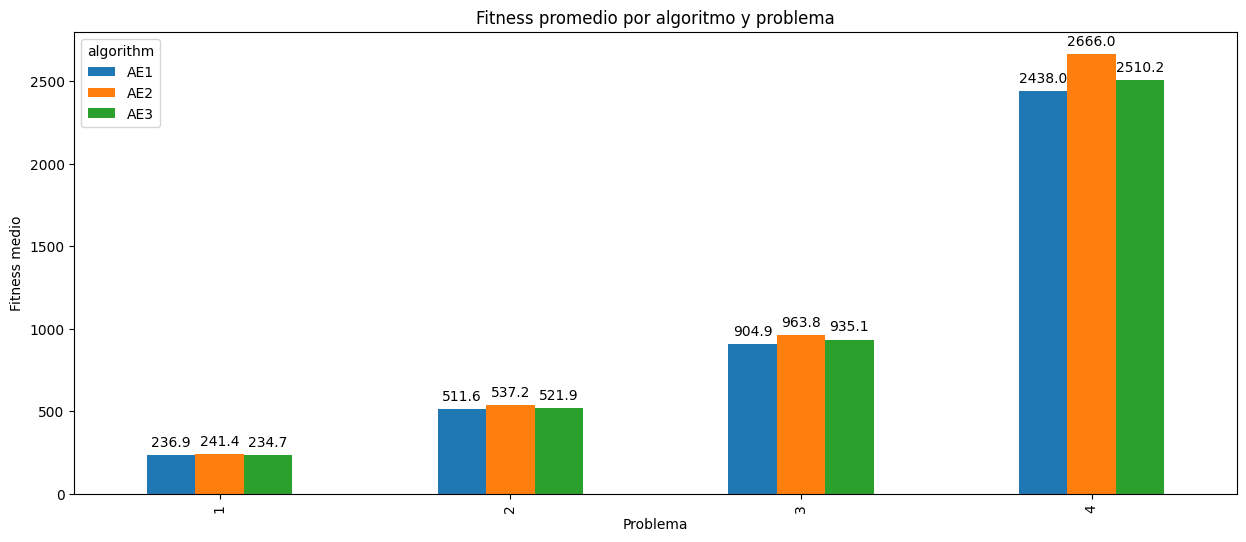

<Figure size 640x480 with 0 Axes>

In [24]:
# Show results_df in a grouped bar plot grouped by problem
results_df_grouped = results_df.groupby(['problem', 'algorithm']).mean().reset_index()
results_df_grouped['mean'] = -results_df_grouped['mean']

fig, ax = plt.subplots(figsize=(15, 6))
pivot_table = results_df_grouped.pivot(index='problem', columns='algorithm', values='mean')
pivot_table.plot(kind='bar', ax=ax)

# Add mean value above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.title('Fitness promedio por algoritmo y problema')
plt.ylabel('Fitness medio')
plt.xlabel('Problema')
plt.show()

plt.savefig(os.path.join(results_dir, 'cbio_p9_fitness.png'))

### Visualización de la evolución del algoritmo

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_0.png


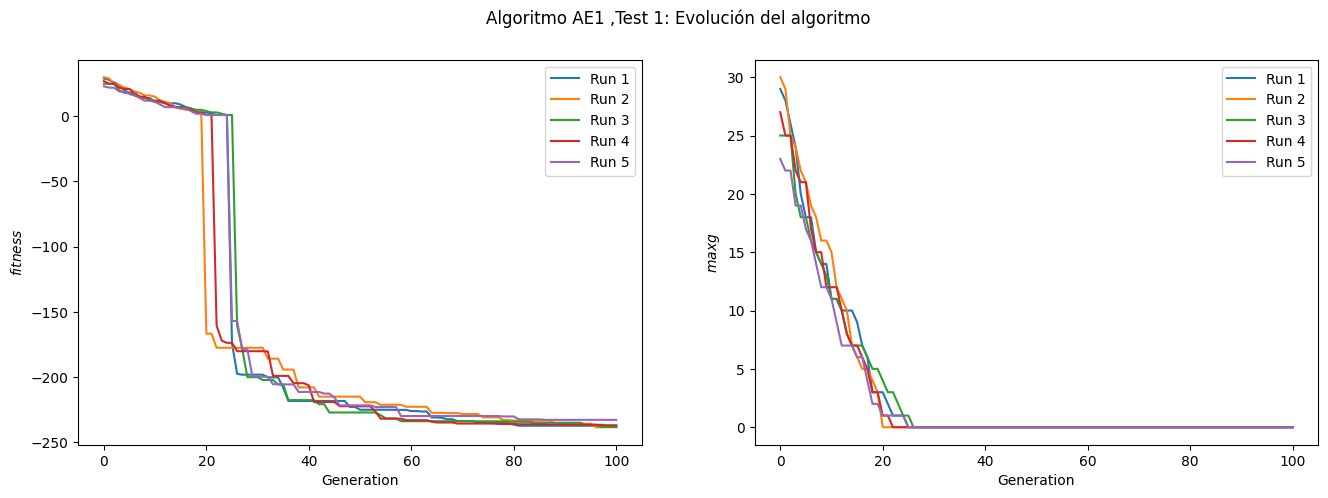

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_1.png


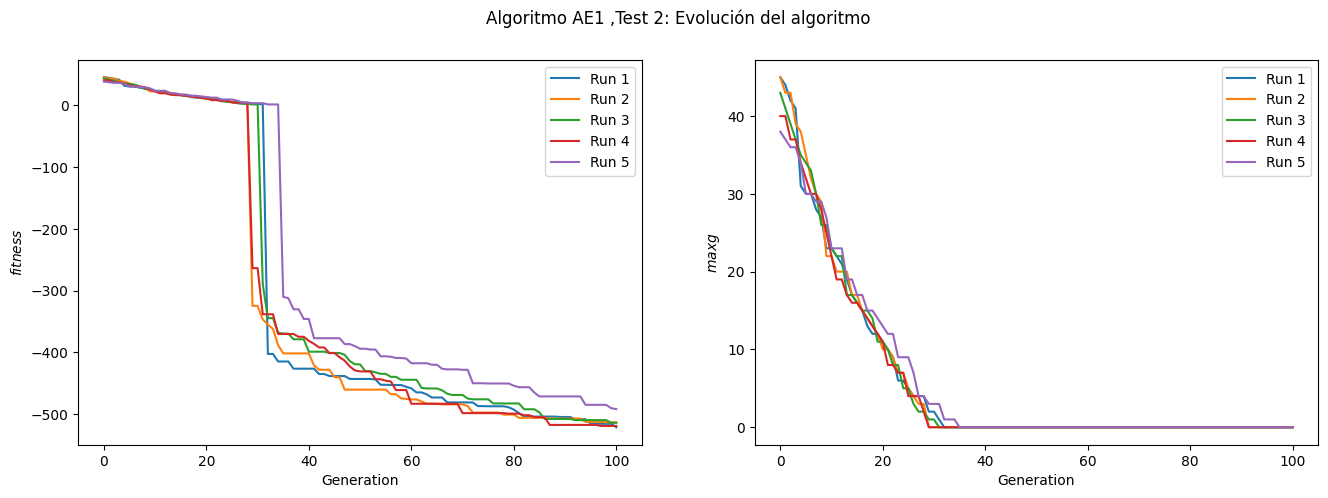

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_2.png


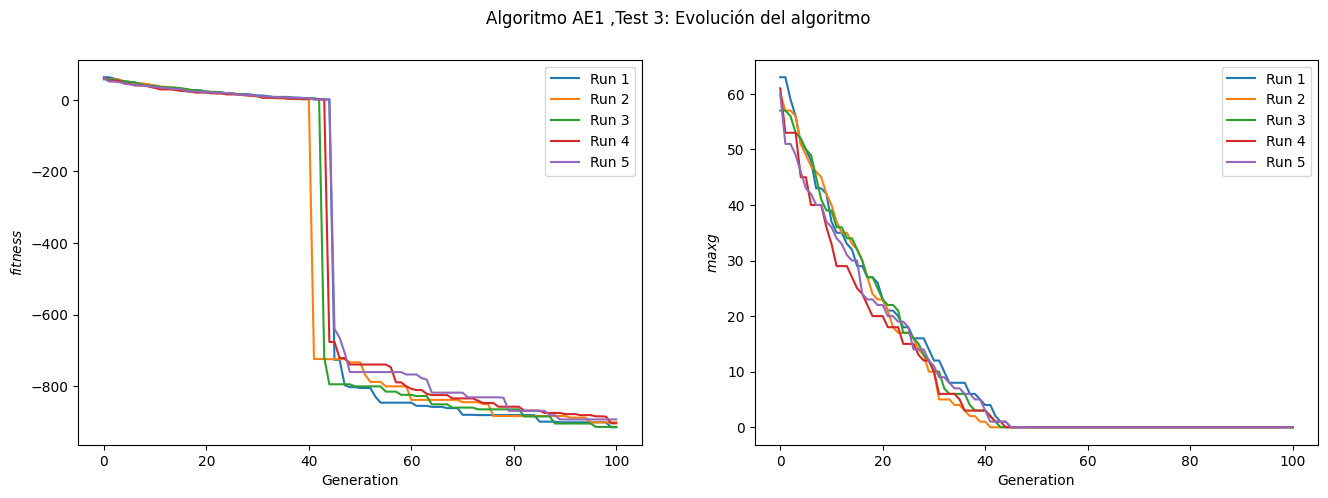

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_3.png


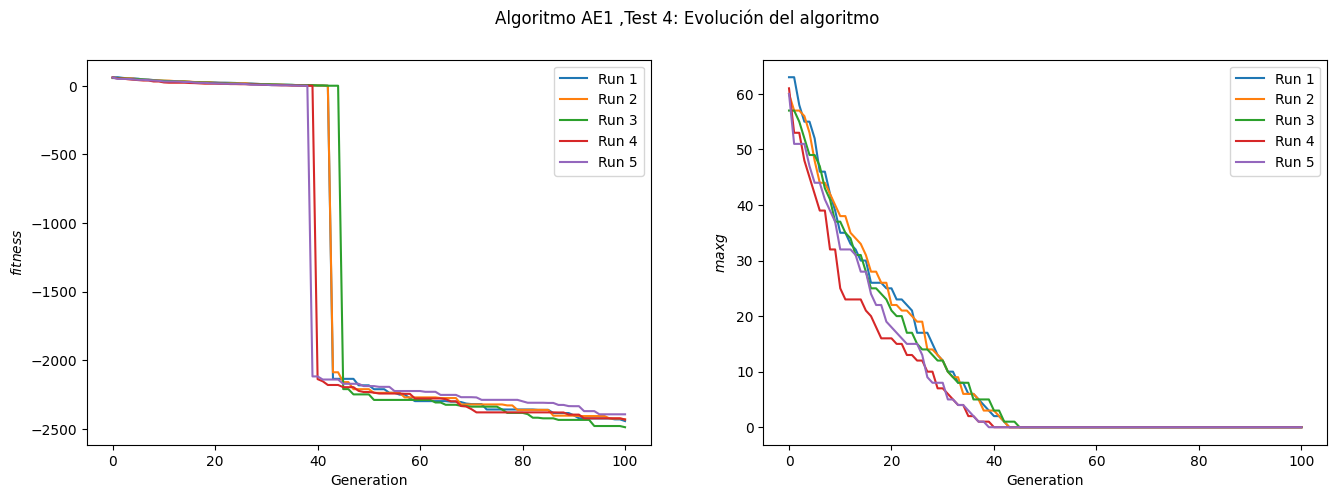

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_0.png


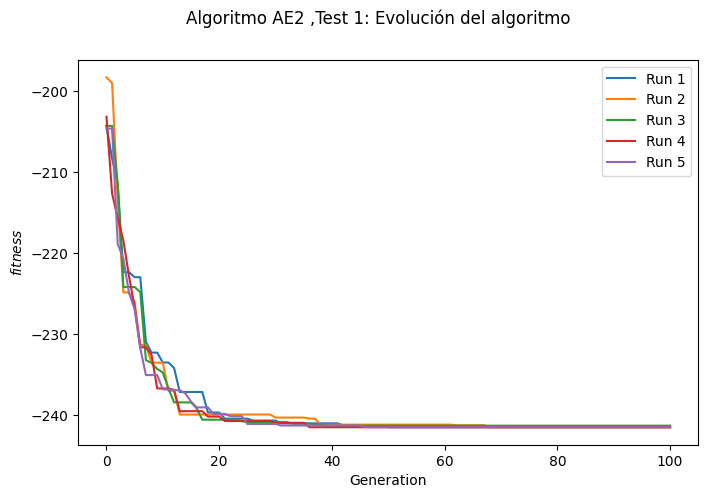

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_1.png


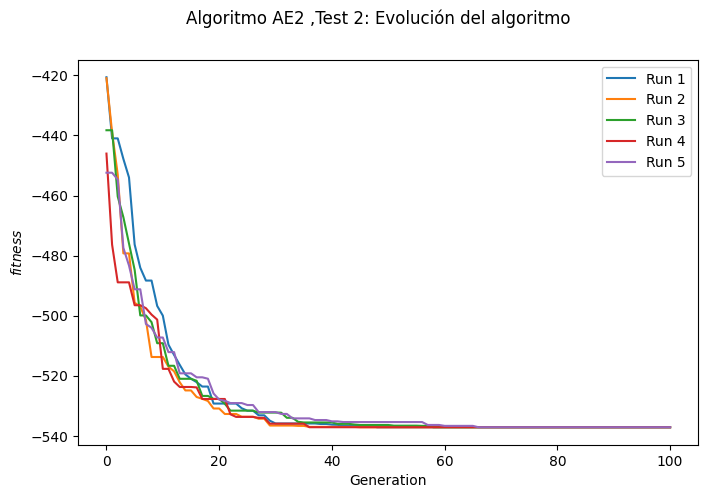

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_2.png


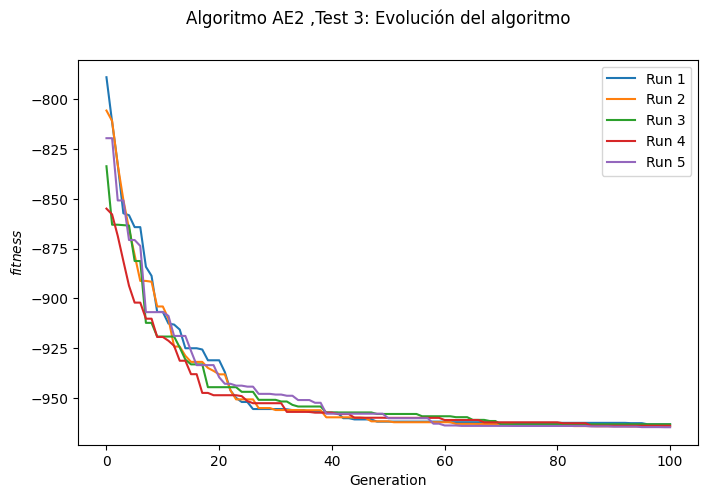

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_3.png


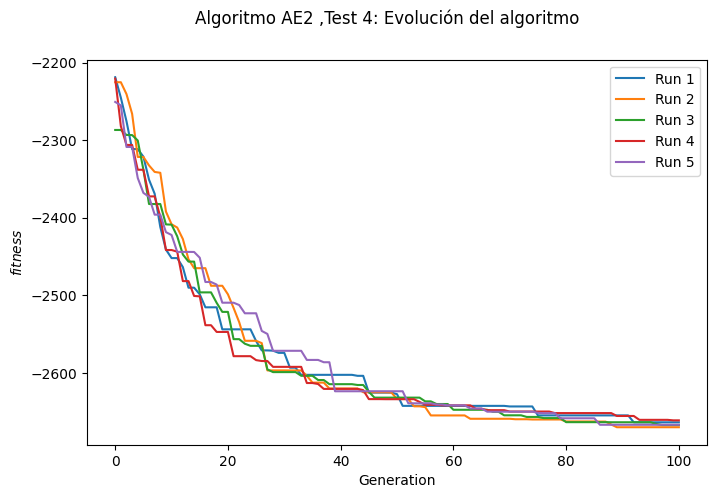

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_0.png


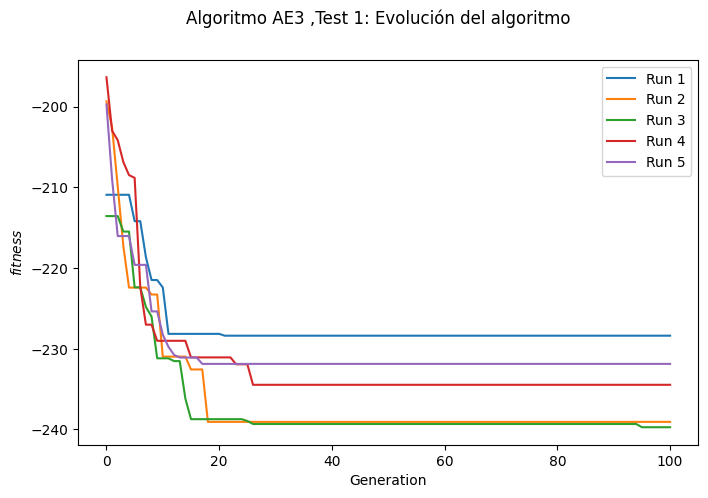

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_1.png


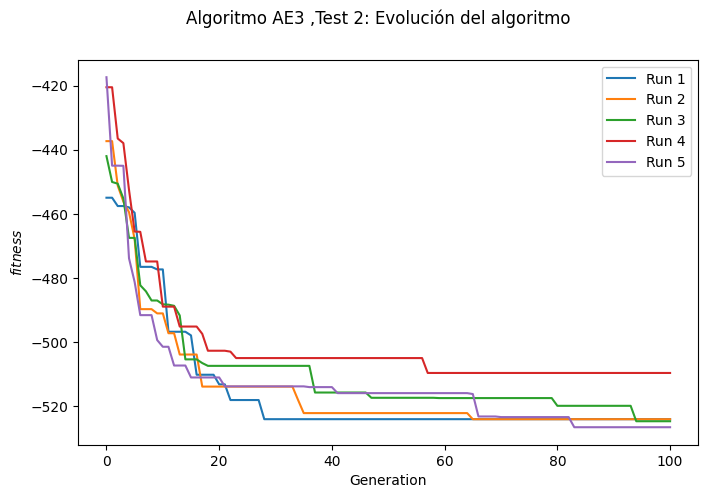

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_2.png


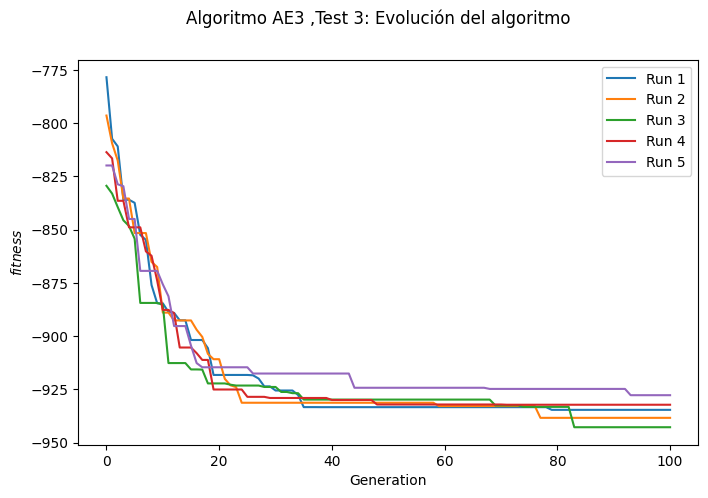

Saved: cbio_p9_results_profiling/EvolutionMuLambdaObjective_3.png


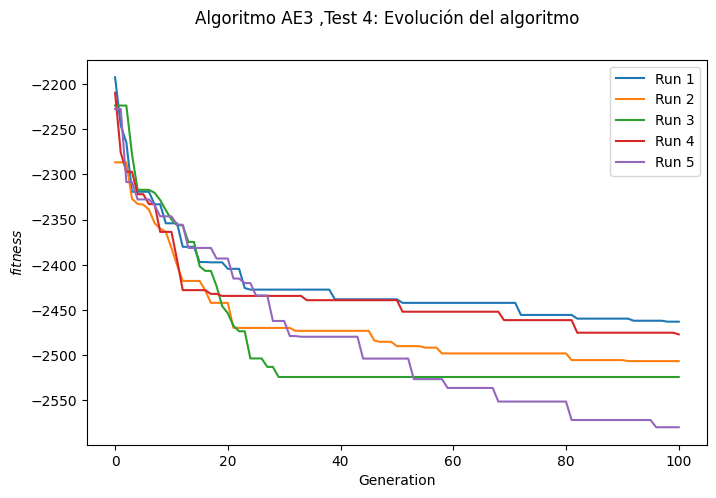

In [25]:
def VisualizaEvolucion(outputs, ylabels, title="Algorithm Evolution", file_prefix=None):
    """
    Muestra una única gráfica con todas las ejecuciones de best_outputs en distintos colores.
    
    Parámetros:
    - best_outputs: np.array de listas con la evolución del fitness en cada run.
    - ylabel: Etiqueta para el eje Y.
    - file_prefix: Prefijo del archivo si se desea guardar la figura.
    """
    
    fig, axes = plt.subplots(nrows=1, ncols = len(outputs), figsize=(8*len(outputs), 5))
    fig.suptitle(title)  # Título común para ambas gráficas
    
    if len(outputs) == 1:
        axes = [axes]
    
    for i, output in enumerate(outputs):
        for j in range(output.shape[0]):
            axes[i].plot(output[j], label=f"Run {j+1}")
            axes[i].set_xlabel("Generation")
            axes[i].set_ylabel(ylabels[i])
            axes[i].legend()
    
    plt.xlabel("Generation")
    plt.legend()
    
    if file_prefix is not None:
        file_path = f"{file_prefix}.png"
        plt.savefig(file_path)
        print(f"Saved: {file_path}")
    
    plt.show()

if not done:
    for nalgorithm, name in enumerate(algorithm_names):
        for nproblem in range(len(problems)):
            outputs = [best_outputs_f[nalgorithm, nproblem, :]]
            if nalgorithm == 0:
                outputs.append(best_outputs_g[nalgorithm, nproblem, :])
            VisualizaEvolucion(outputs, 
                               ["$fitness$", "$maxg$"], 
                               f"Algoritmo {name} ,Test {nproblem+1}: Evolución del algoritmo", 
                               os.path.join(results_dir, f"EvolutionMuLambdaObjective_{nproblem}"))  
else:
    for nalgorithm, name in enumerate(algorithm_names):
        for nproblem in range(len(problems)):
            file_path = os.path.join(results_dir, f"EvolutionMuLambdaObjective_{nproblem}.png")
            print(f"Showing: {file_path}")
            plt.figure(figsize=(15, 5))
            plt.imshow(plt.imread(file_path))            
            plt.axis('off')
            plt.show()

## Solución de cada problema

Al ser $K=1$, si $s_1 \le \cdots \le s_n$, se tiene que existe una solución óptima al problema de la forma:

$$x_i = \begin{cases}
    1 & \text{, si } i \le p \lor i \ge n-m+p+1 \\
    0 & \text{, en otro caso}
\end{cases}$$

para algún $ \lfloor m/2 \rfloor \le p \le \lceil m/2 \rceil$. Por tanto, a lo sumo hay que comprobar 2 posibles soluciones.

In [26]:
# Obtiene la solución de cada problema
def solve(problem):
    perm = np.argsort(problem.X[:,0]) # Sort X and get the permutation
    perm = np.argsort(perm) # invert permutation
    sol = np.zeros(problem.n, dtype=int)
    minf = 0
    for i in range(problem.m//2, (problem.m+1)//2+1):
        x = np.zeros(problem.n, dtype=int)
        x[:i] = 1
        x[problem.n-problem.m+i:] = 1
        x = x[perm] # Apply inverse permutation to x
        f = problem.f(x)
        if f < minf:
            minf = f
            sol = x
    return minf, sol

solutions = [solve(problem) for problem in problems if problem.k == 1]

for i, (f, sol) in enumerate(solutions):
    print("PROBLEMA ", i+1)
    print("Valor objetivo: ", f)
    print("Valor obtenido: ")
    for j in range(len(algorithm_names)):
        print("\t", algorithm_names[j], np.max(best_fitness[j, i, :]))
        print(best_individuos[j, i, np.argmax(best_fitness[j, i, :])] if j != 2 else perm2bin(best_individuos[j, i, np.argmax(best_fitness[j, i, :])], problems[i].m))
    print("Solución: ", sol)

PROBLEMA  1
Valor objetivo:  -241.4837093035511
Valor obtenido: 
	 AE1 -232.90935353074843
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	 AE2 -241.29377086903668
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
	 AE3 -228.37951538517984
[0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
Solución:  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
PROBLEMA  2
Valor objetivo:  -

# Test estadísticos

### Descripción

<font size="4"> Comparación de algoritmos para minimización/maximización utilizando test estadísticos.
    
### Componentes
    
- <font size="3"> Se requiere un fichero csv separado para cada problema. En cada fichero csv, las columnas representan los algoritmos a comparar y las filas son las muestras de los resultados. Las cabeceras de todos los ficheros csv deben ser las mismas.
    
- <font size="3"> Se calculan ranking wins - loss para los siguientes test estadísticos:

    - <font size="3"> Mann-Whitney U test (Wilconxon rank-sum test), apropiado para la comparación  de algoritmos probabilistas ejecutados múltiples veces con distintas semillas (muestras independientes).

- <font size="3"> Se calcula también el ranking wins - loss de los resultados medios. 
    
---

### Definición del tipo de test (maximización o minimización)

In [27]:
def mejor(x,y):
#    return x>y # maximización
    return x<y # minimización

def peor(x,y):
#    return x<y # maximización
    return x>y # minimización

### Definición de la clase Ranking

In [28]:
class Ranking:
    def __init__(self, name):
        self.name = name # Nombre del algoritmo
        self.wins = 0 # Veces que ha ganado
        self.losses = 0 # Veces que ha perdido
    def __lt__(self,x):
        return (self.wins-self.losses) < (x.wins-x.losses)
    def __str__(self):
        return f"{self.name:<15} {self.wins:>10} {self.losses:>10} {self.wins - self.losses:>15}"

### Calcula la matriz de wins - losses de las medias a partir de los scores de un problema

In [29]:
def CalculateWinsLossesMatrixMean(scores):
    labels = scores.columns.values
    nScores = len(labels)
    WinLossMatriz = np.zeros((nScores,nScores)) 
    for i in range(nScores-1):            
        score_i = scores.iloc[:,i].values
        for j in range(i+1,nScores):
            score_j = scores.iloc[:,j].values
            if mejor(mean(score_i),mean(score_j)):
                WinLossMatriz[i,j] = 1
                WinLossMatriz[j,i] = -1
            if peor(mean(score_i),mean(score_j)):
                WinLossMatriz[i,j] = -1
                WinLossMatriz[j,i] = 1
    return WinLossMatriz

### Calcula las veces que cada algoritmo ha ganado y ha perdido a partir de la matriz de wins - losses de un problema

In [30]:
def CalculateWinsLossesAmount(WinsLossesMatriz,labels):
    nScores = len(labels)
    WinsLossesAmount = [Ranking(scoreName) for scoreName in labels]
    for i in range(nScores-1):            
        for j in range(i+1,nScores):
            if WinsLossesMatriz[i,j]==1:            
                WinsLossesAmount[i].wins += 1
                WinsLossesAmount[j].losses += 1
            if WinsLossesMatriz[i,j]==-1:            
                WinsLossesAmount[j].wins += 1
                WinsLossesAmount[i].losses += 1
    return WinsLossesAmount

### Acumula las cantidades de wins - losses de un problema

In [31]:
def AddWinsLossesAmount(WinsLossesTotalAmount,WinsLossesAmount):
    for i in range(len(WinsLossesAmount)):
        WinsLossesTotalAmount[i].wins += WinsLossesAmount[i].wins
        WinsLossesTotalAmount[i].losses += WinsLossesAmount[i].losses

### Calcula la matriz de wins - losses de las diferencias estadísticamente significativas para un test estadistico dado, junto con la matriz de p-values, a partir de los scores de un problema

In [32]:
def CalculateWinsLossesMatrixStat(scores,stat):
    labels = scores.columns.values
    nScores = len(labels)
    WinLossMatriz = np.zeros((nScores,nScores)) 
    pValues = np.zeros((nScores,nScores)) 
    for i in range(nScores-1):            
        score_i = scores.iloc[:,i].values
        for j in range(i+1,nScores):
            score_j = scores.iloc[:,j].values
            if not all(x_i == y_i for x_i, y_i in zip(score_i, score_j)): # si son datos diferentes
                _, p_value = stat(score_i, score_j)  
                pValues[i,j] = p_value
                pValues[j,i] = p_value                
                if p_value<0.05:
                    if mejor(mean(score_i),mean(score_j)):
                        WinLossMatriz[i,j] = 1
                        WinLossMatriz[j,i] = -1                        
                    if peor(mean(score_i),mean(score_j)):
                        WinLossMatriz[i,j] = -1
                        WinLossMatriz[j,i] = 1                        
    return WinLossMatriz,pValues

### Impresión de la matriz wins - losses

In [33]:
def PrintMatriz(WinLossMatriz,labels):
    print("win: El algoritmo en la columna gana al algoritmo de la fila")
    print("loss: El algoritmo en la columna pierde frente al algoritmo de la fila")
    print("tie: El algoritmo en la columna empata con al algoritmo de la fila")
    n = len(labels)
    col_width = 10  # Ancho fijo para cada columna
    # Imprimir encabezados de columna
    print(" " * col_width, end="")
    for j in range(n):
        print(f"{labels[j]:>{col_width}}", end="")
    print()
    for i in range(n):
        print(f"{labels[i]:<{col_width}}", end="")
        for j in range(n):
            if i == j:
                print(f"{'-':>{col_width}}", end="")
            elif WinLossMatriz[j,i] == 1:
                print(f"{'win':>{col_width}}", end="")
            elif WinLossMatriz[j,i] == -1:
                print(f"{'loss':>{col_width}}", end="")
            else:
                print(f"{'tie':>{col_width}}", end="")
        print()

### Impresión  del ranking wins - losses

In [34]:
def PrintRanking(WinLoss):
    Ranking = sorted(WinLoss, reverse=True)    
    print(f"{'Ranking':<15} {'Wins':>10} {'Losses':>10} {'Wins-Losses':>15}")
    for r in Ranking:
        print(r)

### Impresión de la matriz de p-values

In [35]:
def PrintPValuesMatriz(pValues, labels):
    n = len(labels)
    col_width = 15  # Ancho fijo para cada columna, ajusta según sea necesario
    print("p-values")
    # Imprimir encabezados de columna
    print(" " * col_width, end="")
    for j in range(n):
        print(f"{labels[j]:>{col_width}}", end="")
    print()

    # Imprimir filas con datos
    for i in range(n):
        print(f"{labels[i]:<{col_width}}", end="")
        for j in range(n):
            if i == j:
                print(f"{'-':>{col_width}}", end="")
            else:
                print(f"{pValues[i,j]:>{col_width}.8f}", end="")
        print()

### Realización de los test estadísticos e impresión de resultados

In [36]:
#fileName = ["lymphoma_11classes-results","micro-mass-results","GCM-results"] # todas deben tener las mismas cabeceras de algoritmos
# En este ejemplo son sklearn.ensemble.RandomForestClassifier, sklearn.svm.SVC y sklearn.neural_network.MLPClassifier 

#scores = pd.read_csv(fileName[0]+".csv") # Se coje el primero de ellos para crear los objetos de la clase Ranking

labels = algorithm_names 

for i in range(len(problems)):

    print(f"TESTS ESTADÍSTICOS PROBLEMA {i+1}\n")
    WinsLossesTotalAmountMean = [Ranking(scoreName) for scoreName in algorithm_names]
    WinsLossesTotalAmountRanksum = [Ranking(scoreName) for scoreName in algorithm_names]
    
    scores = pd.DataFrame(columns=algorithm_names, data=np.array([best_fitness[nalgorithm, i, :] for nalgorithm in range(len(algorithm_names))]).T)
    print(scores)
    print('\n')
    
    # WINS-LOSSES DE MEDIAS
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    WinsLossesMatrizMean = CalculateWinsLossesMatrixMean(scores) 
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountMean = CalculateWinsLossesAmount(WinsLossesMatrizMean,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountMean,WinsLossesAmountMean)
    print("Mean")
    PrintMatriz(WinsLossesMatrizMean,labels)
    PrintRanking(WinsLossesAmountMean)
    print('\n')
  
    # WINS-LOSSES Y P-VALUES DE RANK-SUM
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    # y matriz de dos dimensiones para los p-values
    WinsLossesMatrizRanksum, pValuesRanksum = CalculateWinsLossesMatrixStat(scores,mannwhitneyu)
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountRanksum = CalculateWinsLossesAmount(WinsLossesMatrizRanksum,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountRanksum,WinsLossesAmountRanksum)
    print("Ranksum")    
    PrintMatriz(WinsLossesMatrizRanksum,labels)
    PrintPValuesMatriz(pValuesRanksum, labels)    
    PrintRanking(WinsLossesAmountRanksum)
    print('\n')
    
        
print("Total Mean")
PrintRanking(WinsLossesTotalAmountMean)
print('\n')

print("Total Ranksum")
PrintRanking(WinsLossesTotalAmountRanksum)
print('\n')

TESTS ESTADÍSTICOS PROBLEMA 1

          AE1         AE2         AE3
0 -237.403184 -241.483709 -228.379515
1 -238.564152 -241.483709 -239.060080
2 -238.348134 -241.293771 -239.722982
3 -237.121671 -241.483709 -234.464886
4 -232.909354 -241.483709 -231.873648


Mean
win: El algoritmo en la columna gana al algoritmo de la fila
loss: El algoritmo en la columna pierde frente al algoritmo de la fila
tie: El algoritmo en la columna empata con al algoritmo de la fila
                 AE1       AE2       AE3
AE1                -       win      loss
AE2             loss         -      loss
AE3              win       win         -
Ranking               Wins     Losses     Wins-Losses
AE2                      2          0               2
AE1                      1          1               0
AE3                      0          2              -2


Ranksum
win: El algoritmo en la columna gana al algoritmo de la fila
loss: El algoritmo en la columna pierde frente al algoritmo de la fila
tie: El algor